# CS 437 - Deep Learning - Assignment 2

*__Submission Instructions:__*
- Rename this notebook to `hw2_rollnumber.ipynb` before submission on LMS.
- All code must be written in this notebook (you do not need to submit any other files).
- The output of all cells must be present in the version of the notebook you submit.
- The university honor code should be maintained. Any violation, if found, will result in disciplinary action. 

In [0]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pydot
from tqdm import tqdm_notebook
from keras.models import Sequential
from keras.layers.core import Dense, Activation

import keras.backend as k

from keras.utils.np_utils import to_categorical
from IPython.display import Image
from ipywidgets import interact, fixed, IntSlider, Play, HBox, jslink

from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split

**Please write your roll number in the next cell**

In [0]:
rollnumber = '20100177'

In this assignment you will be exploring the model parameter space and how the different initializations affect the error surface and the optimization process as a whole. 

Unlike Assignment 1, the tasks this time are disjointed, and can be attempted in any order. 

Take a close look at the `__init__` and `fit` methods for all parts to understand what parameters are available to you and what instance variables have been (if any) setup for you to use. 

In [0]:
# Helper functions
# If you don't fully understand these functions don't worry
# You aren't supposed to understand this per se

def get_error_surface(w1, w2, cls, data):
    model = NeuralNetwork('sgd')
    z = np.zeros_like(w1)
    for row in range(w1.shape[0]):
        for col in range(w1.shape[1]):
            model.weights_[0] = np.array([w1[row,col], w2[row,col]])
            loss = model.evaluate(*data)
            z[row,col] = loss
    return z

def plot_decision_boundary(pred_func, x_min, x_max, y_min, y_max, cmap, ax):
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole ggid
    Z = pred_func(np.c_[xx.flatten(), yy.flatten()])
    Z = Z.reshape(xx.shape)
    # Plot the contour
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)

## Task 1 - Optimizers

In this task you will start with the `NeuralNetwork` class from Assignment 1 (task5) which used Gradient Descent, and modify it to allow for different optimizers. The ones which are compulsory to implement are
- Gradient Descent (already done)
- Momentum

Implement any two of the following optimizers
- Nesterov Accelerated Gradient
- RMS Prop
- Adam
- Adagrad

You will only be modifying the `weight_update` method. Take a close look at the `__init__` method to see which instance variables are available to you (if you want, you can also make your own). You can modify the `fit` function to take as input any hyperparameters ($\gamma$, $\eta$ etc.) required to be passed onto the `weight_update` method. 

You have been provided with visualization code to show the error surface and the path the model takes during training. You should be able to see how the error surface changes for different datasets and how the optimization path changes due to a different optimizer.

*__Note:__ For ease of plotting the model is restricted to just having 2 parameters. This means that the model will be a perceptron with 2 inputs (and no bias )so it can learn a regression function of two inputs. Picture of the model shown here.*
![](./perceptron.png)

In [0]:
class NeuralNetwork():
    @staticmethod
    def mean_squared_error(y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def __init__(self, optimizer):
        '''Creates a Feed-Forward Neural Network.
        "optimizer" is the particular gradient descent strategy used for weight update'''
        self.num_layers = 2 # includes input layer
        self.nodes_per_layer = [2,1]
        self.input_shape = 2
        self.output_shape = 1
        self.optimizer = optimizer
        
        # Values needed for more sophisticated optimizers which require saved state
        self.past_update_amount = 0
        self.last_gradient_value = 0

        self.__init_weights()
    
    def __init_weights(self):
        '''Initializes weights to a dummy value which is better for visualization'''
        self.weights_ = []
        self.weights_.append(np.array([[-10.0,-10.0]]).T)
    
    def fit(self, Xs, Ys, epochs, lr=1e-3, gamma=0.9):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch as well as lists containing weight values for each epoch.'''
        history = []
        w_hist1 = []
        w_hist2 = []
        # START - ADDED BY ME
        alpha = 0.5
        eps = 10 ** -6
        # END
        for epoch in tqdm_notebook(range(epochs)):
            activations = self.forward_pass(Xs)
            deltas = self.backward_pass(Ys, activations)
            
            layer_inputs = [Xs] + activations[:-1]
            self.weight_update(deltas, layer_inputs, lr, gamma, alpha, eps)
                    
            preds = self.predict(Xs)
            current_loss = self.mean_squared_error(preds, Ys)
            
            history.append(current_loss)
            w_hist1.append(self.weights_[0][0][0])
            w_hist2.append(self.weights_[0][1][0])
        return history, w_hist1, w_hist2
    
    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        activations = []
        
        a = input_data.dot(self.weights_[0])
        z = self.sigmoid(a)
        activations.append(z)
        
        return activations
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
        deltas = []
        
        activation_deriv = np.multiply(layer_activations[-1], 1-layer_activations[-1])
        delta = np.multiply((layer_activations[-1] - targets), activation_deriv)
        deltas.append(delta)
        
        return deltas
    
    def weight_update(self, deltas, layer_inputs, lr, gamma, alpha, eps):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate
        "gamma" is the momentum parameter'''
        gradient = np.dot(deltas[0].T, layer_inputs[0]).T

        if self.optimizer == 'sgd':
            update_amount = lr * gradient
        elif self.optimizer == 'momentum':
            if not isinstance(self.past_update_amount, int):
                update_amount = (lr * gradient) - (alpha * self.past_update_amount)
            else:
                update_amount = lr * gradient
            self.past_update_amount = update_amount
        elif self.optimizer == 'nag':
            raise NotImplementedError(f'The {self.optimizer} optimizer has not been implemented yet.')
        elif self.optimizer == 'rmsprop':
            self.last_gradient_value = (self.last_gradient_value * alpha) + ((1 - alpha) * (gradient * gradient))
            update_amount = (lr / np.sqrt(eps + self.last_gradient_value)) * gradient
        elif self.optimizer == 'adam':
            raise NotImplementedError(f'The {self.optimizer} optimizer has not been implemented yet.')
        elif self.optimizer == 'adagrad':
            self.last_gradient_value += (gradient * gradient)
            update_amount = (lr / np.sqrt(eps + self.last_gradient_value)) * gradient

        self.weights_[0] -= update_amount
        
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        return self.forward_pass(Xs)[-1]
    
    def evaluate(self, Xs, Ys):
        '''Returns total MSE for given dataset'''
        pred = self.predict(Xs)
        return self.mean_squared_error(pred, Ys)

__This is a simple regression dataset, you can put any arbitrary binary function here and see how the error surface changes.__

In [66]:
a = np.random.uniform(low=0.0, high=0.5, size=(150,))
b = np.random.uniform(low=0.0, high=0.5, size=(150,))
dataset = pd.DataFrame({
    'var1':   a,
    'var2':   b,
    # 'output': a+b,
    'output': (a**b)+b,
})
print(dataset.shape)
dataset.head()

(150, 3)


,var1,var2,output
0,0.346723,0.391715,1.052111
1,0.420749,0.380459,1.099836
2,0.083134,0.378162,0.768554
3,0.371471,0.368770,1.062837
4,0.342645,0.020344,0.998790


__We train neural networks for all the optimizers and obtain the histories of parameter updates for them. 
These (except GD) will not work for you untill you implement them yourself.__

In [0]:
# write name(nag, rmsprop, adam, adagrad) of two optional optimizers that you have implemented 
opt1 = 'adagrad'
opt2 = 'rmsprop'

epochs = 2000

In [68]:
nn = NeuralNetwork('sgd')
_,w1h_sgd,w2h_sgd = nn.fit(dataset[['var1','var2']].values, dataset[['output']].values, 
                                 epochs=epochs, lr=0.01, gamma=0.9)

nn = NeuralNetwork('momentum')
_,w1h_mome,w2h_mome = nn.fit(dataset[['var1','var2']].values, dataset[['output']].values, 
                                   epochs=epochs, lr=0.01, gamma=0.9)


nn = NeuralNetwork(opt1)
_,w1h_opt1,w2h_opt1 = nn.fit(dataset[['var1','var2']].values, dataset[['output']].values, 
                                   epochs=epochs, lr=0.01, gamma=0.9)

nn = NeuralNetwork(opt2)
_,w1h_opt2,w2h_opt2 = nn.fit(dataset[['var1','var2']].values, dataset[['output']].values, 
                                   epochs=epochs, lr=0.01, gamma=0.9)

__You are not required to understand the inner workings of this plotting function, however you should be able to changes ranges of x and y to control how much of the error surface is shown.__

In [69]:
def make_viz(t):
    x = np.arange(-30,30,0.5)
    y = np.arange(-20,20,0.5)
    x, y = np.meshgrid(x, y)
    z = get_error_surface(x, y, 
                          NeuralNetwork, 
                          (dataset[['var1','var2']].values, dataset[['output']].values))
    if len(plt.gcf().axes) == 4: 
        CS = ax1.contourf(x, y, z, levels=10, cmap='Purples');
        ax1.clabel(CS, inline=False, fontsize=10, colors='k')

        CS = ax2.contourf(x, y, z, levels=10, cmap='Purples');
        ax2.clabel(CS, inline=False, fontsize=10, colors='k')
    
        CS = ax3.contourf(x, y, z, levels=10, cmap='Purples');
        ax3.clabel(CS, inline=False, fontsize=10, colors='k')
    
        CS = ax4.contourf(x, y, z, levels=10, cmap='Purples');
        ax4.clabel(CS, inline=False, fontsize=10, colors='k')

    ax1.plot(w1h_sgd[:t], w2h_sgd[:t], 
             marker='.', markersize=4, c='tab:green');
    ax1.set_title(f'SGD - Epoch {t}');

    ax2.plot(w1h_mome[:t], w2h_mome[:t], 
             marker='.', markersize=4, c='tab:red');
    ax2.set_title(f'Momentum - Epoch {t}');
    
    ax3.plot(w1h_opt1[:t], w2h_opt1[:t], 
             marker='.', markersize=4, c='tab:red');
    ax3.set_title(f'{opt1} - Epoch {t}');
    
    ax4.plot(w1h_opt2[:t], w2h_opt2[:t], 
             marker='.', markersize=4, c='tab:red');
    ax4.set_title(f'{opt2} - Epoch {t}');

    if len(plt.gcf().axes) == 4: 
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(CS, cax=cbar_ax)
    
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(15,12), dpi=80)
fig.suptitle(f'Error Surfaces {rollnumber}')
play = Play(min=0,max=epochs,step=10,value=0)
interact(make_viz, t=play);

<IPython.core.display.Javascript object>

interactive(children=(Play(value=0, description='t', max=2000, step=10), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>

## Task 2 - Weight Initialization

We discussed in class how, due to the complex shape of the error surface, the optimization is very sensitive to the initial parameter values. We will now see this in action by using three completely different weight initialization strategies:
- Zero initialization
- Random Normal Initialization ($\mu = 0, \sigma = 10$)
- [He Initialization](http://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) with variance $\sqrt{\frac{2}{size(l-1)}}$
- [Xavier Initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) with variance ${\frac{1}{size(l-1)}}$

You will only modify the `_init_weights` method. No other method needs to be changed. The `_init_weights` method already contains code for random initialization with standard normal ($\mu = 0, \sigma = 1$). 

We will be using simple zero initialization for biases.

Vizualization code is provided to plot the decision boundary of the binary classification function your model will learn. The different initialization methods will yeild different decision boundaries (some might not converge at all). This effect can also be seen in the plot of error as a function of time/epochs.

Since we are using a very simple dataset, the difference between random normal and normalized initializations will not be that pronounced in the decision boundary, however the training plot might reveal more information.

In [0]:
%matplotlib inline

In [0]:
class NeuralNetwork():
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        return -(y_true * np.log(y_pred)).sum()
    
    @staticmethod
    def accuracy(y_pred, y_true):
        return np.sum(y_pred == y_true)
    
    @staticmethod
    def softmax(x):
        expx = np.exp(x)
        return expx / expx.sum(axis=1, keepdims=True)
    
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def __init__(self, nodes_per_layer, init_strategy='standard_normal'):
        '''Creates a Feed-Forward Neural Network.
        "nodes_per_layer" is a list containing number of nodes in each layer (including input layer)
        "init_strategy" is the weight initialization formula used
        "mode" can be one of 'regression' or 'classification' and controls the output activation as well as training metric'''
        if len(nodes_per_layer) < 2:
            raise ValueError('Network must have atleast 2 layers (input and output).')
        if not (np.array(nodes_per_layer) > 0).all():
            raise ValueError('Number of nodes in all layers must be positive.')
        
        self.num_layers = len(nodes_per_layer) # includes input layer
        self.nodes_per_layer = nodes_per_layer
        self.input_shape = nodes_per_layer[0]
        self.output_shape = nodes_per_layer[-1]
        self.init_strategy = init_strategy
        
        self.__init_weights(nodes_per_layer)
    
    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        self.weights_ = []
        self.biases_ = []
        for i,_ in enumerate(nodes_per_layer):
            if i == 0:
                # skip input layer, it does not have weights/bias
                continue
            
            if self.init_strategy == 'standard_normal':
              weight_matrix = np.random.normal(size=(nodes_per_layer[i-1], nodes_per_layer[i]))
            elif self.init_strategy == 'zeros':
              weight_matrix = np.zeros(shape=(nodes_per_layer[i-1], nodes_per_layer[i]))
            elif self.init_strategy == 'normal':
              weight_matrix = np.random.normal(size=(nodes_per_layer[i-1], nodes_per_layer[i]), scale=10)
            elif self.init_strategy == 'he':
              variance = np.sqrt(2 / nodes_per_layer[i - 1])
              # scale = np.sqrt(variance)
              scale = variance
              weight_matrix = np.random.normal(size=(nodes_per_layer[i-1], nodes_per_layer[i]), scale=scale)
            elif self.init_strategy == 'xavior':
              variance = np.sqrt(1 / nodes_per_layer[i - 1])
              # scale = np.sqrt(variance)
              scale = variance
              weight_matrix = np.random.normal(size=(nodes_per_layer[i-1], nodes_per_layer[i]), scale=scale)

            self.weights_.append(weight_matrix)
            bias_vector = np.zeros(shape=(nodes_per_layer[i],))
            self.biases_.append(bias_vector)
    
    def fit(self, Xs, Ys, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch.'''
        history = []
        for epoch in tqdm_notebook(range(epochs)):
            activations = self.forward_pass(Xs)
            deltas = self.backward_pass(Ys, activations)
            
            layer_inputs = [Xs] + activations[:-1]
            self.weight_update(deltas, layer_inputs, lr)
                    
            preds = self.predict(Xs)
            current_loss = self.cross_entropy_loss(preds, Ys)
            history.append(current_loss)
        return history
    
    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        activations = []
        next_layer_input = input_data
        for i in range(self.num_layers-1):
            intermediate = next_layer_input.dot(self.weights_[i]) + self.biases_[i]
            if i == self.num_layers-2: # output layer
                next_layer_input = self.softmax(intermediate)
            else:
                next_layer_input = self.sigmoid(intermediate)
            activations.append(next_layer_input)
        return activations
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
        deltas = [0] * self.num_layers
        deltas[-1] = layer_activations[-1] - targets
        
        for i in reversed(range(1, self.num_layers-1)): # skip input and output layers
            err = np.dot(self.weights_[i], deltas[i+1].T).T
            activation_deriv = np.multiply(layer_activations[i-1], 1-layer_activations[i-1])
            deltas[i] = np.multiply(err, activation_deriv)
        return deltas[1:]

    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        for i in range(self.num_layers-1):
            self.weights_[i] -= lr * np.dot(deltas[i].T, layer_inputs[i]).T
            self.biases_[i]  -= lr * deltas[i].sum(axis=0)
        
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        return self.forward_pass(Xs)[-1]
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        for i in range(self.num_layers-1):
            for n1 in range(self.nodes_per_layer[i]):
                for n2 in range(self.nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)

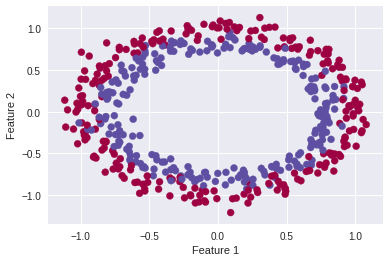

In [72]:
data_x, data_y = make_circles(500, noise=0.07)
plt.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
plt.gca().set(xlabel='Feature 1', ylabel='Feature 2');

### Zeros

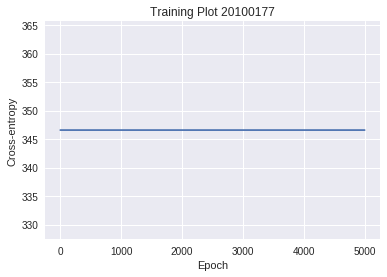

In [73]:
nn = NeuralNetwork([2,10,10,2], init_strategy='zeros')
history = nn.fit(data_x, pd.get_dummies(data_y).values, epochs=5000, lr=1e-2)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title=f'Training Plot {rollnumber}');

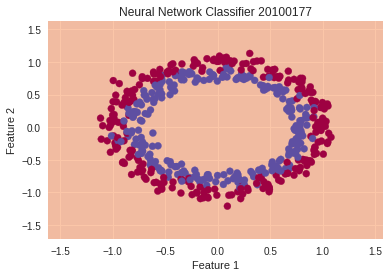

In [74]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier {rollnumber}');

### Random Normal

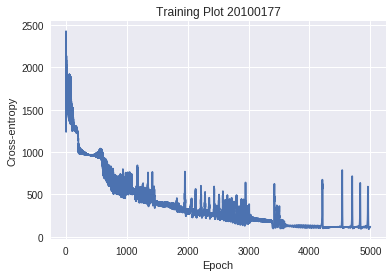

In [77]:
nn = NeuralNetwork([2,10,10,2], init_strategy='normal')
history = nn.fit(data_x, pd.get_dummies(data_y).values, epochs=5000, lr=1e-2)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title=f'Training Plot {rollnumber}');

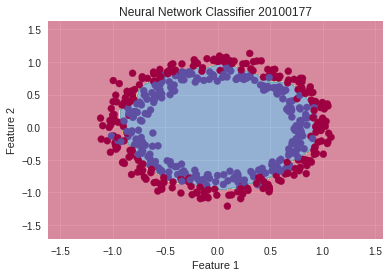

In [78]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier {rollnumber}');

### He

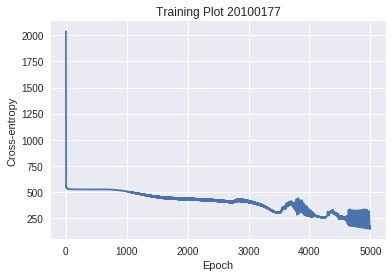

In [79]:
nn = NeuralNetwork([2,10,10,2], init_strategy='he')
history = nn.fit(data_x, pd.get_dummies(data_y).values, epochs=5000, lr=1e-2)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title=f'Training Plot {rollnumber}');

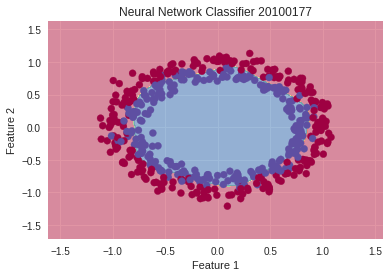

In [80]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier {rollnumber}');

### Xavior

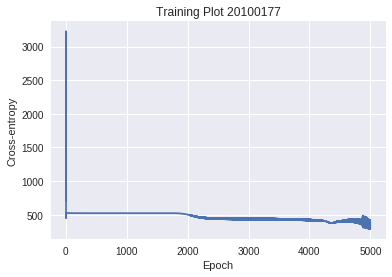

In [83]:
nn = NeuralNetwork([2,10,10,2], init_strategy='xavior')
history = nn.fit(data_x, pd.get_dummies(data_y).values, epochs=5000, lr=1e-2)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title=f'Training Plot {rollnumber}');

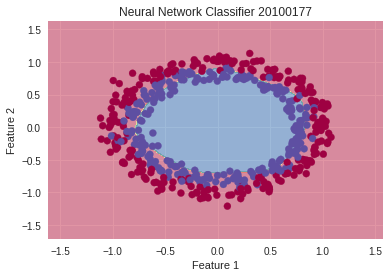

In [84]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier {rollnumber}');

## Task 3 - Regularization

Now we will explore the propensity of Neural Networks to overfit the training data. We will be identifying this phenomenon visually by inspecting the decision boundary, rather than evaluating the model on a test/holdout dataset. 

You will implement __both__ $L_1$ and $L_2$ regularizers in this task.

The only function you need to modify is `weight_update` (or `backward_pass`), `__l1__` and `__l2__` since the `__init__` and `fit` functions have been modified for you.

*Note:* You can add the derivative of the regularizing term in either of the 2 functions dealing with derivatives (it would be simpler in `weight_update`).

Vizualization code is provided to plot the decision boundary of the binary classification function your model will learn. The different regularizers (including no regularization) will show up as different fits over the training data in the plot.

In [0]:
class NeuralNetwork():
    @staticmethod
    def mean_squared_error(y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)
    
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        return -(y_true * np.log(y_pred)).sum()
    
    @staticmethod
    def accuracy(y_pred, y_true):
        return np.sum(y_pred == y_true)
    
    @staticmethod
    def softmax(x):
        expx = np.exp(x)
        return expx / expx.sum(axis=1, keepdims=True)
    
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def __init__(self, nodes_per_layer, regularization='none', reg_factor=0.0):
        '''Creates a Feed-Forward Neural Network.
        "nodes_per_layer" is a list containing number of nodes in each layer (including input layer)
        "regularization" is one of {l1,l2,None}
        "reg_factor" is teh lambda parameter in the regularized loss equation 
        "mode" can be one of 'regression' or 'classification' and controls the output activation as well as training metric'''
        if len(nodes_per_layer) < 2:
            raise ValueError('Network must have atleast 2 layers (input and output).')
        if not (np.array(nodes_per_layer) > 0).all():
            raise ValueError('Number of nodes in all layers must be positive.')
        
        self.num_layers = len(nodes_per_layer) # includes input layer
        self.nodes_per_layer = nodes_per_layer
        self.input_shape = nodes_per_layer[0]
        self.output_shape = nodes_per_layer[-1]
        self.regularization = regularization
        self.reg_factor = reg_factor
        
        self.__init_weights(nodes_per_layer)
    
    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        self.weights_ = []
        self.biases_ = []
        for i,_ in enumerate(nodes_per_layer):
            if i == 0:
                # skip input layer, it does not have weights/bias
                continue
            
            weight_matrix = np.random.normal(size=(nodes_per_layer[i-1], nodes_per_layer[i]))
            self.weights_.append(weight_matrix)
            bias_vector = np.zeros(shape=(nodes_per_layer[i],))
            self.biases_.append(bias_vector)
    
    def __l1__(self):
        ret_val = 0
        for weights in self.weights_:
          ret_val += self.reg_factor * np.sum(abs(weights))
        return ret_val
        # return self.reg_factor * np.sum(abs(weights))
    
    def __l2__(self):
        # return ((self.weights_[-1].T @ self.weights_[-1]) * self.reg_factor) / 2)
        ret_val = 0
        for weights in self.weights_:
          ret_val += np.sum((weights.T @ weights).T) * self.reg_factor / 2
        return ret_val
    
    def fit(self, Xs, Ys, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch.'''
        history = []
        for epoch in tqdm_notebook(range(epochs)):
            activations = self.forward_pass(Xs)
            deltas = self.backward_pass(Ys, activations)
            
            layer_inputs = [Xs] + activations[:-1]
            self.weight_update(deltas, layer_inputs, lr)
                    
            preds = self.predict(Xs)
            
            regularization_amount = 0
            if self.regularization == 'l1':
                regularization_amount = self.__l1__()
            elif self.regularization == 'l2':
                regularization_amount = self.__l2__()
            
            current_loss = self.cross_entropy_loss(preds, Ys) + regularization_amount
            history.append(current_loss)
        return history
    
    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        activations = []
        next_layer_input = input_data
        for i in range(self.num_layers-1):
            intermediate = next_layer_input.dot(self.weights_[i]) + self.biases_[i]
            if i == self.num_layers-2: # output layer
                next_layer_input = self.softmax(intermediate)
            else:
                next_layer_input = self.sigmoid(intermediate)
            activations.append(next_layer_input)
        return activations
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
        deltas = [0] * self.num_layers
        deltas[-1] = layer_activations[-1] - targets
        
        for i in reversed(range(1, self.num_layers-1)): # skip input and output layers
            err = np.dot(self.weights_[i], deltas[i+1].T).T
            activation_deriv = np.multiply(layer_activations[i-1], 1-layer_activations[i-1])
            deltas[i] = np.multiply(err, activation_deriv)
        return deltas[1:]

    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        alpha = self.reg_factor
        for i in range(self.num_layers-1):
            if self.regularization == 'l1':
                J_grad = (deltas[i].T @ layer_inputs[i]).T
                self.weights_[i] -= lr * ((alpha * np.sign(self.weights_[i])) + J_grad)
                # raise NotImplementedError(f'{self.regularization} regularization is not implemented.')
            elif self.regularization == 'l2':
                J_grad = (deltas[i].T @ layer_inputs[i]).T
                self.weights_[i] -= lr *((alpha * self.weights_[i]) + J_grad)
                # raise NotImplementedError(f'{self.regularization} regularization is not implemented.')
            elif self.regularization == 'none':
                self.weights_[i] -= lr * np.dot(deltas[i].T, layer_inputs[i]).T
            self.biases_[i]  -= lr * deltas[i].sum(axis=0)
        
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        return self.forward_pass(Xs)[-1]
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        for i in range(self.num_layers-1):
            for n1 in range(self.nodes_per_layer[i]):
                for n2 in range(self.nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)

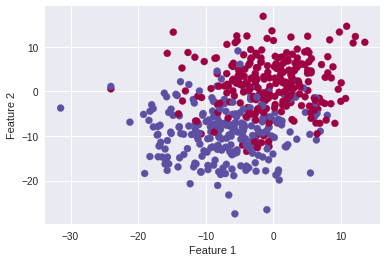

In [86]:
data_x, data_y = make_blobs(500, centers=2, cluster_std=6)
plt.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
plt.gca().set(xlabel='Feature 1', ylabel='Feature 2');

### No Regularization

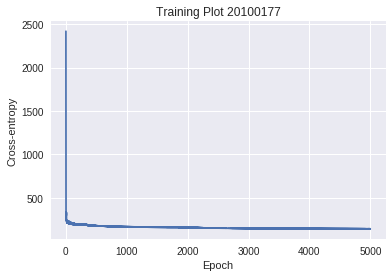

In [87]:
nn = NeuralNetwork([2,10,10,2], regularization='none', reg_factor=0.0)
history = nn.fit(data_x, pd.get_dummies(data_y).values, epochs=5000, lr=1e-2)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title=f'Training Plot {rollnumber}');

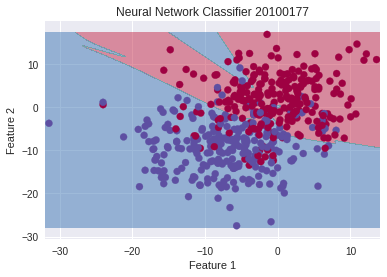

In [88]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier {rollnumber}');

### $L_1$ Regularization

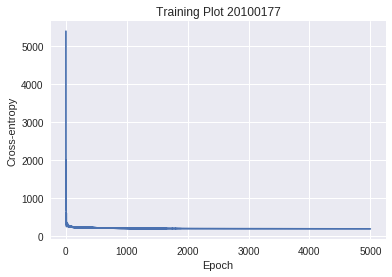

In [89]:
nn = NeuralNetwork([2,10,10,2], regularization='l1', reg_factor=0.3)
history = nn.fit(data_x, pd.get_dummies(data_y).values, epochs=5000, lr=1e-2)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title=f'Training Plot {rollnumber}');

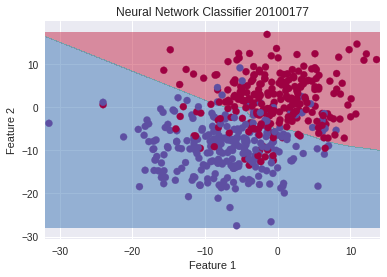

In [90]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier {rollnumber}');

### $L_2$ Regularization

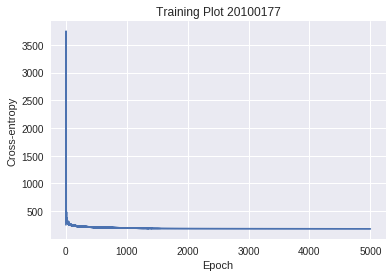

In [91]:
nn = NeuralNetwork([2,10,10,2], regularization='l2', reg_factor=0.3)
history = nn.fit(data_x, pd.get_dummies(data_y).values, epochs=5000, lr=1e-2)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title=f'Training Plot {rollnumber}');

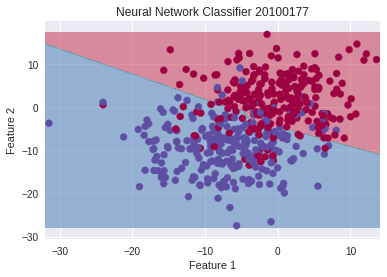

In [92]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier {rollnumber}');

## Task 4 - Loss Functions

Now we will see how the choice of error function determines the performance of the model for a particular task. This task will also serve as a practical introduction to the basics of Keras.

The code to create and evaluate the model has been provided to you already. All you need to do is fill in the `mean_squared_error`, `cross_entropy_loss` and `root_mean_squared_logarithmic_error` functions and use them appropriately. 

You will use all these loss functions to learn regression as well as classification and then compare the results via the plots.

You should keep an eye on the loss plot generated after training and the values of evaluation metrics.

### Regression

In [0]:
batch_size = 128
num_classes = 1
class_labels = np.arange(0, num_classes, 1)
epochs = 30

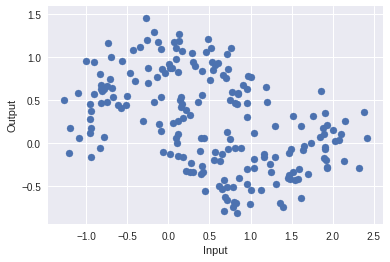

In [102]:
data_x, data_y = make_moons(200, noise=0.18)
plt.scatter(data_x[:,0], data_x[:,1]);
plt.gca().set(xlabel='Input', ylabel='Output');

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.30, shuffle=True)
x_train = data_x[:, 0]
y_train = data_y
x_test, y_test = make_moons(100, noise=0.18)

In [103]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(1,), name='input_l'))
model.add(Dense(50, activation='relu', name='hidden_l'))
model.add(Dense(num_classes, activation='relu', name='output_l'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_l (Dense)              (None, 50)                100       
_________________________________________________________________
hidden_l (Dense)             (None, 50)                2550      
_________________________________________________________________
output_l (Dense)             (None, 1)                 51        
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________


In [0]:
def mean_squared_error(y_pred, y_true):
    return k.mean((y_pred - y_true) ** 2, axis=-1)

def cross_entropy_loss(y_pred, y_true):
    value = (y_true + 1.) * k.log(y_pred + 1.)
    return -k.sum(value, axis=-1)

def root_mean_squared_logarithmic_error(y_pred, y_true):
    first_log = k.log(y_pred + 1.)
    second_log = k.log(y_true + 1.)
    return k.mean((first_log - second_log) ** 2, axis=-1)

In [0]:
model.compile(loss=mean_squared_error,
              optimizer='sgd',
              metrics=['accuracy'])

In [111]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/30
200/200 [==============================] - 0s 1ms/step - loss: 0.5014 - acc: 0.5000
Epoch 2/30
200/200 [==============================] - 0s 34us/step - loss: 0.5013 - acc: 0.5000
Epoch 3/30
200/200 [==============================] - 0s 33us/step - loss: 0.5013 - acc: 0.5000
Epoch 4/30
200/200 [==============================] - 0s 31us/step - loss: 0.5012 - acc: 0.5000
Epoch 5/30
200/200 [==============================] - 0s 31us/step - loss: 0.5012 - acc: 0.5000
Epoch 6/30
200/200 [==============================] - 0s 27us/step - loss: 0.5012 - acc: 0.5000
Epoch 7/30
200/200 [==============================] - 0s 28us/step - loss: 0.5011 - acc: 0.5000
Epoch 8/30
200/200 [==============================] - 0s 27us/step - loss: 0.5011 - acc: 0.5000
Epoch 9/30
200/200 [==============================] - 0s 25us/step - loss: 0.5010 - acc: 0.5000
Epoch 10/30
200/200 [==============================] - 0s 28us/step - loss: 0.5010 - acc: 0.5000
Epoch 11/30
200/200 [===================

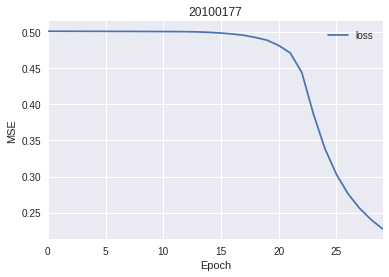

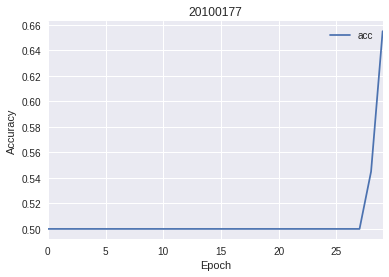

In [112]:
h = pd.DataFrame(history.history)

h[['loss']].plot();
plt.gca().set_xlabel('Epoch');
plt.gca().set_ylabel('MSE');
plt.gca().set_title(f'{rollnumber}');

h[['acc']].plot();
plt.gca().set_xlabel('Epoch');
plt.gca().set_ylabel('Accuracy');
plt.gca().set_title(f'{rollnumber}');

In [113]:
score = model.evaluate(x_test[:,0], y_test, 
                       verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

100/100 [==============================] - 0s 1ms/step
Test loss: 0.21880683422088623
Test accuracy: 0.69


In [114]:
d = np.arange(-1.5, 2.5, 0.1).reshape((40,1))
preds = model.predict(d, verbose=1)

40/40 [==============================] - 0s 3ms/step


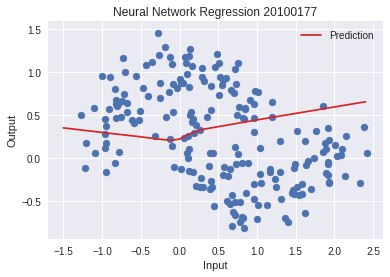

In [115]:
fig, ax = plt.subplots()
ax.scatter(data_x[:,0].reshape((200,1)), data_x[:,1].reshape((200,1)));
ax.plot(d.flatten(), preds.flatten(), c='tab:red', label='Prediction');
ax.set(xlabel='Input', ylabel='Output', title=f'Neural Network Regression {rollnumber}');
ax.legend();

### Classification

In [0]:
batch_size = 128
num_classes = 2
class_labels = np.arange(0,1)
epochs = 30

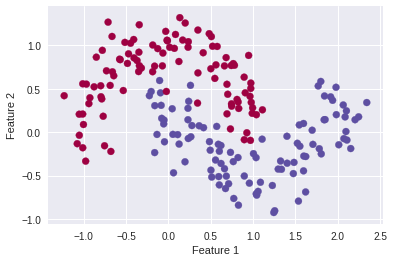

In [117]:
data_x, data_y = make_moons(200, noise=0.20)
plt.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
plt.gca().set(xlabel='Feature 1', ylabel='Feature 2');

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.30, shuffle=True)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [118]:
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(2,), name='input_l'))
model.add(Dense(50, activation='relu', name='hidden_l'))
model.add(Dense(num_classes, activation='softmax', name='output_l'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_l (Dense)              (None, 50)                150       
_________________________________________________________________
hidden_l (Dense)             (None, 50)                2550      
_________________________________________________________________
output_l (Dense)             (None, 2)                 102       
Total params: 2,802
Trainable params: 2,802
Non-trainable params: 0
_________________________________________________________________


In [0]:
def mean_squared_error(y_pred, y_true):
    return k.mean((y_pred - y_true) ** 2, axis=-1)

def cross_entropy_loss(y_pred, y_true):
    value = (y_true + 1.) * k.log(y_pred + 1.)
    return -k.sum(value, axis=-1)

def root_mean_squared_logarithmic_error(y_pred, y_true):
    first_log = k.log(y_pred + 1.)
    second_log = k.log(y_true + 1.)
    return k.mean((first_log - second_log) ** 2, axis=-1)

In [0]:
model.compile(loss=root_mean_squared_logarithmic_error,
              optimizer='sgd',
              metrics=['accuracy'])

In [132]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/30
140/140 [==============================] - 0s 3ms/step - loss: 0.1059 - acc: 0.7429
Epoch 2/30
140/140 [==============================] - 0s 37us/step - loss: 0.1057 - acc: 0.7429
Epoch 3/30
140/140 [==============================] - 0s 37us/step - loss: 0.1056 - acc: 0.7429
Epoch 4/30
140/140 [==============================] - 0s 36us/step - loss: 0.1054 - acc: 0.7500
Epoch 5/30
140/140 [==============================] - 0s 36us/step - loss: 0.1053 - acc: 0.7500
Epoch 6/30
140/140 [==============================] - 0s 41us/step - loss: 0.1052 - acc: 0.7500
Epoch 7/30
140/140 [==============================] - 0s 40us/step - loss: 0.1050 - acc: 0.7571
Epoch 8/30
140/140 [==============================] - 0s 36us/step - loss: 0.1049 - acc: 0.7571
Epoch 9/30
140/140 [==============================] - 0s 40us/step - loss: 0.1047 - acc: 0.7571
Epoch 10/30
140/140 [==============================] - 0s 43us/step - loss: 0.1046 - acc: 0.7571
Epoch 11/30
140/140 [===================

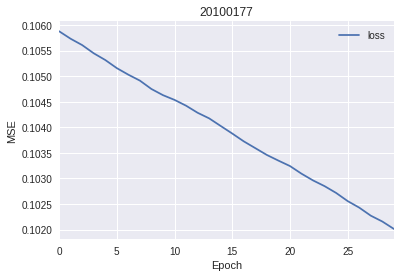

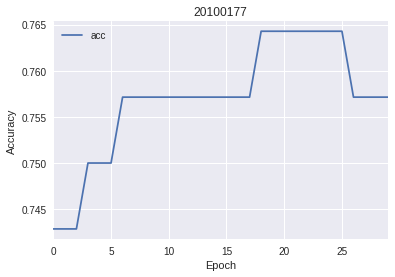

In [133]:
h = pd.DataFrame(history.history)

h[['loss']].plot();
plt.gca().set_xlabel('Epoch');
plt.gca().set_ylabel('MSE');
plt.gca().set_title(f'{rollnumber}');

h[['acc']].plot();
plt.gca().set_xlabel('Epoch');
plt.gca().set_ylabel('Accuracy');
plt.gca().set_title(f'{rollnumber}');

In [134]:
score = model.evaluate(x_test, y_test, 
                       verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

60/60 [==============================] - 0s 3ms/step
Test loss: 0.09463833669821421
Test accuracy: 0.8166666785875957


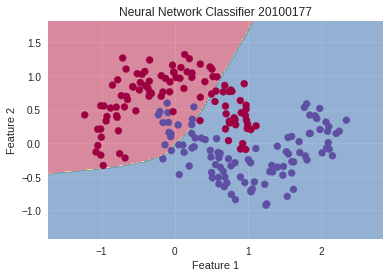

In [135]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: model.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral);
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier {rollnumber}');